In [2]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
import os
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.metrics

import sklearn.datasets
import warnings
import scipy
from scipy.stats import f_oneway
warnings.filterwarnings("ignore")

In [3]:
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
sns.set_style(style='white')

In [4]:
from sklearn.cluster import KMeans

### Load in TAD and Boundary Data

In [5]:
common_TADs_total = pd.read_csv("../common_TADs_meQTLs.csv")
common_TADs_total

,Unnamed: 0,chr1,x1,x2,chr2,y1,y2,color,f1,f2,...,H3K27me3,H4K20me1,#meqtl,KMeans_State_Labels,#meqtl_pos,#meqtl_neg,domain_size,norm_meqtl_by_size,norm_pos_meqtl_by_size,norm_neg_meqtl_by_size
0,0,1,36960000,37910000,1,36960000,37910000,"255,255,0",1.8249,0.079690,...,0.167622,0.705304,206,4,71,141,950000,0.062006,0.021654,0.047834
1,1,1,38485000,39310000,1,38485000,39310000,"255,255,0",1.7513,0.051417,...,0.226065,0.369001,219,4,122,97,825000,0.075906,0.042846,0.037893
2,2,1,157140000,157480000,1,157140000,157480000,"255,255,0",1.3679,0.065425,...,0.275085,0.000000,283,4,90,194,340000,0.238009,0.076695,0.183891
3,3,1,64075000,64730000,1,64075000,64730000,"255,255,0",1.3300,0.074093,...,0.244738,0.000000,301,4,201,189,655000,0.131405,0.088911,0.092995
4,4,1,110325000,110530000,1,110325000,110530000,"255,255,0",1.5128,0.032783,...,0.499037,0.704529,38,0,26,22,205000,0.053005,0.036747,0.034587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1095,X,117750000,117955000,X,117750000,117955000,"255,255,0",1.2678,0.032125,...,0.000000,0.000000,0,0,0,0,205000,0.000000,0.000000,0.000000
1096,1096,X,37785000,38035000,X,37785000,38035000,"255,255,0",1.5301,0.051187,...,1.000000,0.000000,0,1,0,0,250000,0.000000,0.000000,0.000000
1097,1097,X,109150000,109385000,X,109150000,109385000,"255,255,0",1.0945,0.040047,...,0.000000,1.000000,0,1,0,0,235000,0.000000,0.000000,0.000000
1098,1098,X,102790000,102945000,X,102790000,102945000,"255,255,0",1.2129,0.041055,...,0.000000,0.000000,0,1,0,0,155000,0.000000,0.000000,0.000000


In [6]:
tads_50kb = pd.read_csv("../tads_50kb_boundary.csv")
tads_50kb

,Unnamed: 0,chr1,x1,x2,Label
0,0,1,7345000,7660000,Inactive
1,1,1,7295000,7345000,Boundary-Inactive
2,2,1,7660000,7710000,Boundary-Inactive
3,3,1,7710000,7712500,Boundary-Inactive
4,4,1,7712500,7715000,Boundary-Inactive
...,...,...,...,...,...
5429,5429,X,133905000,133955000,Boundary-Inactive
5430,5430,X,149060000,149110000,Boundary-Inactive
5431,5431,X,149160000,149845000,Inactive
5432,5432,X,149110000,149160000,Boundary-Inactive


### Load in Clumped meQTL Data

In [7]:
unique_meqtls = pd.read_csv("../unique_meqtls.csv")
unique_meqtls

,Unnamed: 0,cancer_type,rsid,snp_position,alleles,probes,probe_position,probe_gene,beta,status,r,p-value,cancer,chr,bp,SNP
0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,MYADML,-1.24,-40.26,-0.90,3.940000e-139,BLCA,chr2,33952621,2:33952621:G:A
1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.59,-0.90,6.710000e-137,BLCA,chr2,33954560,2:33954560:C:T
2,2,BLCA,rs7574695,chr2:33953186,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.35,-0.90,4.230000e-136,BLCA,chr2,33953186,2:33953186:C:T
3,3,BLCA,rs11777332,chr8:91676709,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91676709,8:91676709:G:A
4,4,BLCA,rs4332092,chr8:91677926,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91677926,8:91677926:G:A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236137,1236137,UCEC,rs60260871,chr3:124711371,C/T,cg11029367,chr3:124705145,HEG1,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711371,3:124711371:C:T
1236138,1236138,UCEC,rs57574713,chr3:124711386,G/A,cg11029367,chr3:124705145,HEG1,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711386,3:124711386:G:A
1236139,1236139,UCEC,rs10903612,chr10:2018353,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2018353,10:2018353:C:T
1236140,1236140,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2019373,10:2019373:C:T


In [8]:
clumped_meqtls = pd.read_csv("../all_meqtls.clumped", delim_whitespace=True)
clumped_meqtls

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2
0,9,1,9:37136359:C:G,37136359,2.610000e-186,84,0,0,0,0,84,"9:37070209:C:T(1),9:37070374:G:A(1),9:37072434..."
1,4,1,4:60004266:T:C,60004266,4.220000e-159,262,0,0,0,0,262,"4:59978132:A:G(1),4:59978891:A:T(1),4:59983686..."
2,2,1,2:239335473:T:C,239335473,7.620000e-151,33,0,0,0,0,33,"2:239318389:T:C(1),2:239320505:A:G(1),2:239323..."
3,1,1,1:156165290:T:G,156165290,1.920000e-147,63,0,0,0,0,63,"1:156156094:G:A(1),1:156156789:A:G(1),1:156156..."
4,2,1,2:33952621:G:A,33952621,3.940000e-139,77,0,0,0,0,77,"2:33940162:C:G(1),2:33940918:G:A(1),2:33941247..."
...,...,...,...,...,...,...,...,...,...,...,...,...
60599,4,1,4:4795176:T:C,4795176,9.990000e-06,0,0,0,0,0,0,NONE
60600,6,1,6:23487567:T:C,23487567,9.990000e-06,0,0,0,0,0,0,NONE
60601,7,1,7:154416644:A:G,154416644,9.990000e-06,0,0,0,0,0,0,NONE
60602,10,1,10:31390127:A:G,31390127,9.990000e-06,0,0,0,0,0,0,NONE


In [9]:
clumped_meqtls['CHR'] = clumped_meqtls['CHR'].apply(str)

### Calculate Burden of meQTLs in TADs Normalized by TAD Size

In [10]:
def count_meqtls_tads(tad):
    num_unique_meqtls = []
    for i, row in tad.iterrows():
        if i%100 == 0:
            print(i)
        overlap_chr = unique_meqtls[unique_meqtls["chr"] == "chr"+str(row["chr1"])]
        overlap_snps = overlap_chr[((overlap_chr["bp"]) >= int(row["x1"])) & ((overlap_chr["bp"]) <= int(row["x2"]))]
        num_unique_meqtls.append(len(overlap_snps)/(row["x2"]-row["x1"]))
    tad["unique_meqtl"] = num_unique_meqtls
    return tad

In [11]:
def count_clumped_meqtls_tads(tad):
    num_unique_meqtls = []
    for i, row in tad.iterrows():
        overlap_chr = clumped_meqtls[(clumped_meqtls["CHR"]) == str(row["chr1"])]
        overlap_snps = overlap_chr[((overlap_chr["BP"]) >= int(row["x1"])) & ((overlap_chr["BP"]) <= int(row["x2"]))]
        num_unique_meqtls.append((len(overlap_snps)/(row["x2"]-row["x1"]))*1000)
    tad["unique_meqtl"] = num_unique_meqtls
    return tad

In [12]:
tads_50kb = count_meqtls_tads(tads_50kb)

0
100
200
300


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [13]:
tads_50kb = count_clumped_meqtls_tads(tads_50kb)
tads_50kb

,Unnamed: 0,chr1,x1,x2,Label,unique_meqtl
0,0,1,7345000,7660000,Inactive,0.04127
1,1,1,7295000,7345000,Boundary-Inactive,0.16000
2,2,1,7660000,7710000,Boundary-Inactive,0.02000
3,3,1,7710000,7712500,Boundary-Inactive,0.00000
4,4,1,7712500,7715000,Boundary-Inactive,0.00000
...,...,...,...,...,...,...
5429,5429,X,133905000,133955000,Boundary-Inactive,0.00000
5430,5430,X,149060000,149110000,Boundary-Inactive,0.00000
5431,5431,X,149160000,149845000,Inactive,0.00000
5432,5432,X,149110000,149160000,Boundary-Inactive,0.00000


In [14]:
common_TADs_total = count_meqtls_tads(common_TADs_total)

0
100
200
300
400
500
600
700
800
900
1000


In [15]:
active_TADs_50kb = tads_50kb[tads_50kb["Label"] == "Active"]
inactive_TADs_50kb = tads_50kb[tads_50kb["Label"] == "Inactive"]
mixed_TADs_50kb = tads_50kb[tads_50kb["Label"] == "Mixed"]
boundary_TADs_50kb = tads_50kb[tads_50kb["Label"].str.contains("Boundary")]
boundary_active_TADs_50kb = tads_50kb[tads_50kb["Label"] == "Boundary-Active"]
boundary_inactive_TADs_50kb = tads_50kb[tads_50kb["Label"] == "Boundary-Inactive"]

num_active_TADs_meqtls_50kb = np.array(active_TADs_50kb["unique_meqtl"])
num_inactive_TADs_meqtls_50kb = np.array(inactive_TADs_50kb["unique_meqtl"])
num_mixed_TADs_meqtls_50kb = np.array(mixed_TADs_50kb["unique_meqtl"])
num_boundary_TADs_meqtls_50kb = np.array(boundary_TADs_50kb["unique_meqtl"])
num_boundary_active_TADs_meqtls_50kb = np.array(boundary_active_TADs_50kb["unique_meqtl"])
num_boundary_inactive_TADs_meqtls_50kb = np.array(boundary_inactive_TADs_50kb["unique_meqtl"])

### Run a Student-T test 

In [38]:
print(stats.ttest_ind(num_boundary_TADs_meqtls_20kb, num_active_TADs_meqtls_20kb, equal_var=False))
print(stats.ttest_ind(num_boundary_TADs_meqtls_20kb, num_inactive_TADs_meqtls_20kb, equal_var=False))
print(stats.ttest_ind(num_boundary_TADs_meqtls_20kb, num_mixed_TADs_meqtls_20kb, equal_var=False))

Ttest_indResult(statistic=-1.5027622682039288, pvalue=0.13406447798533094)
Ttest_indResult(statistic=6.012775864378171, pvalue=2.3663384412674843e-09)
Ttest_indResult(statistic=0.5397802237399518, pvalue=0.5897261069485201)


In [46]:
print(stats.ttest_ind(num_boundary_active_TADs_meqtls_20kb, num_active_TADs_meqtls_20kb, equal_var=False))
print(stats.ttest_ind(num_boundary_inactive_TADs_meqtls_20kb, num_inactive_TADs_meqtls_20kb, equal_var=False))

Ttest_indResult(statistic=0.3694924569260761, pvalue=0.7119398206038928)
Ttest_indResult(statistic=3.999503511494604, pvalue=6.599587498377255e-05)


In [22]:
print(stats.ttest_ind(num_boundary_TADs_meqtls_50kb, num_active_TADs_meqtls_50kb, equal_var=False))
print(stats.ttest_ind(num_boundary_TADs_meqtls_50kb, num_inactive_TADs_meqtls_50kb, equal_var=False))
print(stats.ttest_ind(num_boundary_TADs_meqtls_50kb, num_mixed_TADs_meqtls_50kb, equal_var=False))
print(stats.ttest_ind(num_active_TADs_meqtls_50kb, num_inactive_TADs_meqtls_50kb, equal_var=False))

Ttest_indResult(statistic=3.096190632376862, pvalue=0.0021531803599444998)
Ttest_indResult(statistic=0.07195273201590079, pvalue=0.9426540546586907)
Ttest_indResult(statistic=1.5813018893360076, pvalue=0.114791952573324)
Ttest_indResult(statistic=-2.620663295819284, pvalue=0.009057480472595202)


In [33]:
print(stats.ttest_ind(num_boundary_active_TADs_meqtls_50kb, num_active_TADs_meqtls_50kb, equal_var=False))
print(stats.ttest_ind(num_boundary_inactive_TADs_meqtls_50kb, num_inactive_TADs_meqtls_50kb, equal_var=False))

Ttest_indResult(statistic=1.4118092519659264, pvalue=0.15860283986857737)
Ttest_indResult(statistic=0.743873439472722, pvalue=0.4570838915561657)


In [16]:
tads_50kb_short = tads_50kb[~tads_50kb["Label"].str.contains("Mixed")]
tads_50kb_short = tads_50kb_short.rename(columns={"unique_meqtl":"Normalized Burden of meQTLs", "Label":"TAD Type"})
tads_50kb_short

,Unnamed: 0,chr1,x1,x2,TAD Type,Normalized Burden of meQTLs
0,0,1,7345000,7660000,Inactive,0.04127
1,1,1,7295000,7345000,Boundary-Inactive,0.16000
2,2,1,7660000,7710000,Boundary-Inactive,0.02000
3,3,1,7710000,7712500,Boundary-Inactive,0.00000
4,4,1,7712500,7715000,Boundary-Inactive,0.00000
...,...,...,...,...,...,...
5429,5429,X,133905000,133955000,Boundary-Inactive,0.00000
5430,5430,X,149060000,149110000,Boundary-Inactive,0.00000
5431,5431,X,149160000,149845000,Inactive,0.00000
5432,5432,X,149110000,149160000,Boundary-Inactive,0.00000


In [19]:
tads_50kb_short = tads_50kb_short[tads_50kb_short["TAD Type"].isin(["Inactive", "Active"])]

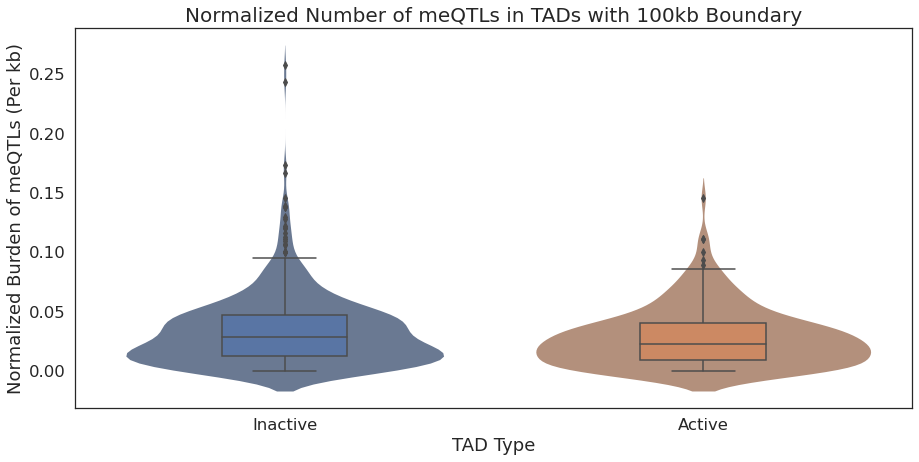

In [22]:
sns.set(font_scale=1.5)
sns.set_style("white")
fig_histone2 = plt.figure(figsize =(15, 7))
ax = sns.violinplot(x="TAD Type", y="Normalized Burden of meQTLs", data=tads_50kb_short, inner=None, linewidth=0, saturation=0.4)
# sns.violinplot(data=tips, x='day', y='total_bill', palette='turbo',
#                     inner=None, linewidth=0, saturation=0.4)
b = sns.boxplot(x="TAD Type", y="Normalized Burden of meQTLs", data=tads_50kb_short, width=0.3,
            boxprops={'zorder': 2}, ax=ax)
b.set_ylabel("Normalized Burden of meQTLs (Per kb)")
plt.title("Normalized Number of meQTLs in TADs with 100kb Boundary", fontsize=20)
plt.savefig("../plots/overall_meqtl_distribution_violin.png")
plt.savefig("../plots/overall_meqtl_distribution_violin.pdf")

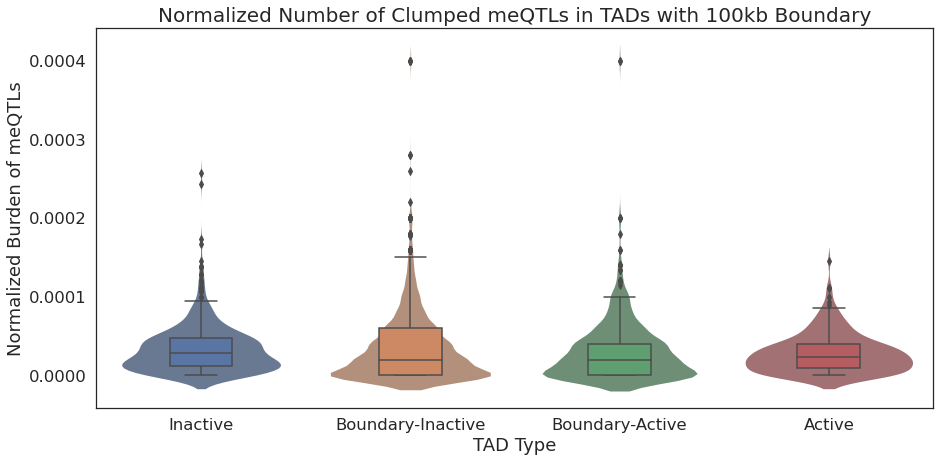

In [23]:
##sns.set(font_scale=1.5)
sns.set_style("white")
fig_histone2 = plt.figure(figsize =(15, 7))
ax = sns.violinplot(x="TAD Type", y="Normalized Burden of meQTLs", data=tads_50kb_short, inner=None, linewidth=0, saturation=0.4)
# sns.violinplot(data=tips, x='day', y='total_bill', palette='turbo',
#                     inner=None, linewidth=0, saturation=0.4)
sns.boxplot(x="TAD Type", y="Normalized Burden of meQTLs", data=tads_50kb_short, width=0.3,
            boxprops={'zorder': 2}, ax=ax)
plt.title("Normalized Number of Clumped meQTLs in TADs with 100kb Boundary", fontsize=20)
plt.savefig("../plots/overall_clumped_meqtl_distribution_violin.png")
plt.savefig("../plots/overall_clumped_meqtl_distribution_violin.pdf")